In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
from utils import *

# massIVE-KB
- https://massive.ucsd.edu/ProteoSAFe/static/massive-kb-libraries.jsp


- Human HCD spectral library derived from over 30TB of human MS/MS proteomics data and including ProteomeTools synthetic peptides
    - proteins : 19,611
    - precursors : 2,154,269
    - peptides : 1,114,503

# MGF file

In [24]:
tmp = open('data/massIVE-KB/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-download_filtered_mgf_library-main.mgf')
for _ in range(100):
    print(tmp.readline())
tmp.close()

BEGIN IONS

PEPMASS=623.3276257633

CHARGE=3

MSLEVEL=2

COLLISION_ENERGY=0.0

FILENAME=filtered_library_mgf_files/9187af535f6e41ce9583b4553469c20e.mgf

SEQ=+42.011AAEAAGGKYRSTVSKSKD

PROTEIN=sp|Q96A65|EXOC4_HUMAN

SCANS=1

SCAN=1

SCORE=4.6051746015

FDR=0.0

129.10317993164062	63295.375

130.08726501464844	7010.876953125

136.07666015625	14278.6826171875

143.0828857421875	5026.0068359375

147.11407470703125	7820.40576171875

155.08229064941406	4797.83935546875

161.09341430664062	12979.1123046875

173.09310913085938	12697.0185546875

185.09327697753906	46881.85546875

189.08819580078125	8073.11181640625

198.1256561279297	5272.4541015625

201.08811950683594	40607.234375

216.13560485839844	25192.845703125

262.1419982910156	13653.341796875

272.1259765625	9055.1015625

314.1366882324219	39298.5859375

315.1393737792969	6137.8544921875

349.172607421875	12984.642578125

385.17431640625	22504.26953125

397.213623046875	10097.7060546875

444.7332763671875	4657.58154296875

495.26116943

In [25]:
kb = open('data/massIVE-KB/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-download_filtered_mgf_library-main.mgf', 'r')
kblines = kb.readlines()
kb.close()
rows = {'PEPMASS':[], 'CHARGE':[], 'MSLEVEL':[], 'COLLISION_ENERGY':[], 'FILENAME':[], 'SEQ':[],
       'PROTEIN':[], 'STRIP_PEPTIDE':[], 'SCANS':[], 'SCAN':[], 'SCORE':[], 'FDR':[], 'MZ':[], 'INTENSITY':[]}
ms2mz = []
ms2int = []
for line in kblines:
    line = line.replace('\n', '')
    if 'PEPMASS=' in line:
        rows['PEPMASS'].append(line.replace('PEPMASS=', ''))
    elif 'CHARGE=' in line:
        rows['CHARGE'].append(line.replace('CHARGE=', ''))
    elif 'MSLEVEL=' in line:
        rows['MSLEVEL'].append(line.replace('MSLEVEL=', ''))
    elif 'COLLISION_ENERGY=' in line:
        rows['COLLISION_ENERGY'].append(line.replace('COLLISION_ENERGY=', ''))
    elif 'FILENAME=' in line:
        rows['FILENAME'].append(line.replace('FILENAME=', ''))
    elif 'SEQ=' in line:
        rows['SEQ'].append(line.replace('SEQ=', ''))
        rows['STRIP_PEPTIDE'].append(''.join(list(filter(lambda x: ord(x) in range(65, 91), line.replace('SEQ=', '')))))
    elif 'PROTEIN=' in line:
        rows['PROTEIN'].append(line.replace('PROTEIN=', ''))
    elif 'SCANS=' in line:
        rows['SCANS'].append(line.replace('SCANS=', ''))
    elif 'SCAN=' in line:
        rows['SCAN'].append(line.replace('SCAN=', ''))
    elif 'SCORE=' in line:
        rows['SCORE'].append(line.replace('SCORE=', ''))
    elif 'FDR=' in line:
        rows['FDR'].append(line.replace('FDR=', ''))
    elif '\t' in line:
        mz, inten = line.split('\t')
        ms2mz.append(mz)
        ms2int.append(inten)      
    elif 'END IONS' in line:
        rows['MZ'].append(';'.join(ms2mz))
        rows['INTENSITY'].append(';'.join(ms2int))
        ms2mz = []
        ms2int = []

In [26]:
df_kb = pd.DataFrame(rows)

print(df_kb.shape)
df_kb.head(2)

In [43]:
# find PK
print('pk check : ', len(df_kb) == len({(SEQ, CHARGE) for SEQ, CHARGE in df_kb[['SEQ', 'CHARGE']].values}),
      '\nunique peptide with not modified cnt : ', len({_ for _ in df_kb.SEQ.values if '+' not in _}))

pk check :  True 
unique peptide cnt :  897881


# All Candidate Library Spectra file
  - for spectral count of peptide
  - STRIP_PEPTIDE count가 아니라, experiment의 spectral count를 세야 한다.
      - filename 으로 구분해야한다.

In [7]:
df_candi = pd.read_csv('data/massIVE-KB/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-candidate_library_spectra-main.tsv', sep='\t')
print(df_candi.shape)
df_candi.head(2)

In [44]:
# check experiment count
print('unique file(experiment) cnt : {:,}'.format(len(df_candi.filename.unique())))

unique file(experiment) cnt : 27,992


In [58]:
# check same pk
candi_uniqset = {(SEQ, CHARGE) for SEQ, CHARGE in df_candi[['annotation', 'charge']].values}
kb_uniqset = {(SEQ, int(CHARGE)) for SEQ, CHARGE in df_kb[['SEQ', 'CHARGE']].values}

print(len(candi_uniqset), 
      len(kb_uniqset),
      len(candi_uniqset.intersection(kb_uniqset)))

In [60]:
# (annotation, charge) : filename
precursor2fn = dict()
for p, c, fn in df_candi[['annotation', 'charge', 'filename']].values:
    if (p, c) not in precursor2fn:
        precursor2fn[(p, c)] = set()
    precursor2fn[(p, c)].add(fn)

precursor2cnt = {k:len(v) for k, v in precursor2fn.items()}

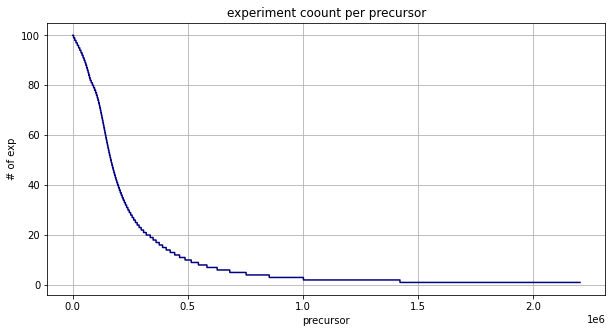

In [63]:
viz = sorted(precursor2cnt.items(), key=lambda x: x[1], reverse=True)
x = range(len([i[0] for i in viz]))
y = [i[1] for i in viz]

plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('precursor')
plt.ylabel('# of exp')
plt.title('experiment coount per precursor')
plt.grid()
plt.show()

# Merge

In [66]:
df_kb['SPECTRAL_CNT'] = [precursor2cnt[(S, int(C))] for S, C in df_kb[['SEQ', 'CHARGE']].values]

In [67]:
df_kb.head(1)

,PEPMASS,CHARGE,FILENAME,SEQ,PROTEIN,STRIP_PEPTIDE,SCORE,MZ,INTENSITY,SPECTRAL_CNT
0,623.3276257633,3,filtered_library_mgf_files/9187af535f6e41ce958...,+42.011AAEAAGGKYRSTVSKSKD,sp|Q96A65|EXOC4_HUMAN,AAEAAGGKYRSTVSKSKD,4.6051746015,129.10317993164062;130.08726501464844;136.0766...,63295.375;7010.876953125;14278.6826171875;5026...,1


# Del 

In [35]:
# del columns
print(df_kb.MSLEVEL.unique(),
     df_kb.COLLISION_ENERGY.unique(),
     len(df_kb)==len(df_kb.SCANS.unique()),
     len(df_kb)==len(df_kb.SCAN.unique()),
     df_kb.FDR.unique())

df_kb.drop(['MSLEVEL', 'COLLISION_ENERGY', 'SCANS', 'SCAN', 'FDR'], axis=1, inplace=True)

['2'] ['0.0'] True True ['0.0']


In [74]:
# del decoy proteins (including protein which not exist in uniprot)
df_uni = pd.read_csv('data/uniprot/df_uni.csv')
prot = [__ for _ in df_kb.PROTEIN.values for __ in _.split(';')]

inter_prot = set(prot).intersection(set(df_uni.PROTEIN.unique()))
onlykb_prot = set(prot).difference(set(df_uni.PROTEIN.unique()))
else_prot = [_ for _ in onlykb_prot if 'XXX' not in _]
decoy_prot = [_ for _ in onlykb_prot if 'XXX' in _]
print('unique protein cnt : {:,}'.format(len(set(prot))))
print('massiveKB intersect uniprotDB cnt : {:,}'.format(len(inter_prot)))
print('only massiveKB protein cnt :{:,}'.format(len(onlykb_prot)))
print('decoy protein cnt :{:,}'.format(len(decoy_prot)))
print('decoy protein example ', decoy_prot[:2])
print('else protein cnt :{:,}'.format(len(else_prot)))
print('else protein example', else_prot[:2])

# remove precursor which has only decoy protein
prot = []
for p in df_kb.PROTEIN.values:
    p_list = p.split(';')
    inter = set(p_list).intersection(decoy_prot)
    if len(inter) >= 1:
        [p_list.remove(_) for _ in inter]
    prot.append(';'.join(p_list))
df_kb['PROTEIN_except_decoy'] = prot

decoy_idx = df_kb.loc[df_kb.PROTEIN_except_decoy==''].index
print('deleted total precursor: {:,}'.format(len(decoy_idx)))

df_kb.drop(decoy_idx, inplace=True)
df_kb.reset_index(drop=True, inplace=True)

# remove else protein (not exist in uniprot)
prot = []
for p in df_kb.PROTEIN_except_decoy.values:
    p_list = p.split(';')
    inter = set(p_list).intersection(else_prot)
    if len(inter) >= 1:
        [p_list.remove(_) for _ in inter]
    prot.append(';'.join(p_list))
df_kb['PROTEIN_except_else'] = prot

else_idx = df_kb.loc[df_kb.PROTEIN_except_else==''].index
print('deleted total row : {:,}'.format(len(else_idx)))

df_kb.drop(else_idx, inplace=True)
df_kb.reset_index(drop=True, inplace=True)

unique protein cnt : 23,458
massiveKB intersect uniprotDB cnt : 19,301
only massiveKB protein cnt :4,157
decoy protein cnt :3,892
decoy protein example  ['XXX_sp|Q9Y345|SC6A5_HUMAN', 'XXX_sp|H3BNL1|CC084_HUMAN']
else protein cnt :265
else protein example ['sp|Q6P9B6|TLDC1_HUMAN', 'sp|P30457|1A66_HUMAN']
deleted total precursor: 0
deleted total row : 0


In [76]:
df_kb.drop(['PROTEIN_except_decoy', 'PROTEIN'], axis=1, inplace=True)
df_kb.rename({'PROTEIN_except_else':'PROTEIN'}, axis=1, inplace=True)

# EDA

In [79]:
prot = [__ for _ in df_kb.PROTEIN.values for __ in _.split(';')]
print('unique protein cnt : {:,}\nunique peptide cnt : {:,}\nunique stripped peptide cnt : {:,}'.format(
    len(set(prot)), len(df_kb.SEQ.unique()), len(df_kb.STRIP_PEPTIDE.unique())))
print('unique precursor cnt : {:,}'.format(len(df_kb)))

unique protein cnt : 19,301
unique peptide cnt : 1,547,644
unique stripped peptide cnt : 1,075,839
unique precursor cnt : 2,110,805


* peptide length distribution

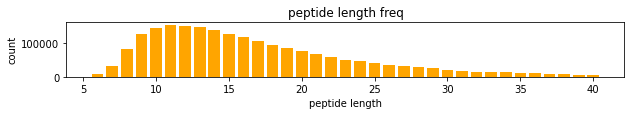

In [80]:
length_viz = {len(i):[] for i in df_kb.STRIP_PEPTIDE.values}
for i in df_kb.STRIP_PEPTIDE.values:
    length_viz[len(i)].append(i)
    
length_viz = {k:len(v) for k, v in length_viz.items()}
x = length_viz.keys()
y = length_viz.values()
plt.figure(figsize=(10,1))
plt.bar(x, y, color='orange')
plt.title('peptide length freq')
plt.xlabel('peptide length')
plt.ylabel('count')
plt.show()

In [82]:
print(min(x), max(x))

6 40


In [85]:
# peptide length 7~30 count
print('7~30 length cnt : {:,}\n7~30 length ratio : {:.2f}'.format(
    sum(length_viz[k] for k in range(7, 31)), sum(length_viz[k] for k in range(7, 31))/len(df_kb)))

7~30 length cnt : 1,992,213
7~30 length ratio : 0.94


* missed cleavage distribution

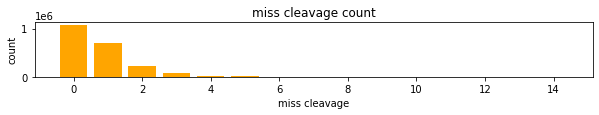

In [83]:
tmp = [[i for i in pep[:-1] if i in 'KR'] for pep in df_kb.STRIP_PEPTIDE.values]
miss_dic = {len(i):0 for i in tmp}
for i in tmp:
    miss_dic[len(i)] += 1

x = miss_dic.keys()
y = miss_dic.values()
plt.figure(figsize=(10,1))
plt.bar(x, y, color='orange')
plt.title('miss cleavage count')
plt.xlabel('miss cleavage')
plt.ylabel('count')
plt.show()

In [87]:
print('0~2 miss cleavage cnt : {:,}\n0~2 miss cleavage ratio : {:.2f}'.format(
    sum(miss_dic[k] for k in range(0,3)), sum(miss_dic[k] for k in range(0,3))/len(df_kb)))

0~2 miss cleavage cnt : 2,005,376
0~2 miss cleavage ratio : 0.95


* charge distribution

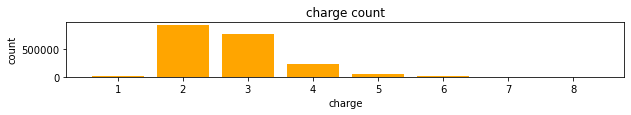

In [8]:
tmp = [c for c in df_kb.CHARGE.values]
charge_dic = {c:0 for c in tmp}
for c in tmp:
    charge_dic[c] += 1

x = charge_dic.keys()
y = charge_dic.values()
plt.figure(figsize=(10,1))
plt.bar(x, y, color='orange')
plt.title('charge count')
plt.xlabel('charge')
plt.ylabel('count')
plt.show()

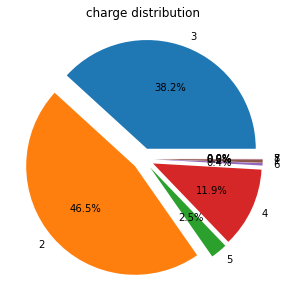

In [16]:
plt.figure(figsize=(5,5))
plt.pie(charge_dic.values(), autopct='%1.1f%%', labels=charge_dic.keys(), explode=[0.1]*len(charge_dic))
plt.title('charge distribution')
plt.show()

In [18]:
print('1~6 charge rows / total rows : ', sum([charge_dic[k] for k in range(1, 7)]) / len(df_kb))

1~6 charge rows / total rows :  0.9996245381392451


# Filtration peptide length 7~30

In [104]:
df_kb_filter = df_kb.loc[df_kb.STRIP_PEPTIDE.apply(lambda x: (len(x)>=7)&(len(x)<=30))].reset_index(drop=True)

In [105]:
print(df_kb_filter.shape)
df_kb_filter.head(1)

(1992213, 10)


,PEPMASS,CHARGE,FILENAME,SEQ,STRIP_PEPTIDE,SCORE,MZ,INTENSITY,SPECTRAL_CNT,PROTEIN
0,623.3276257633,3,filtered_library_mgf_files/9187af535f6e41ce958...,+42.011AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,4.6051746015,129.10317993164062;130.08726501464844;136.0766...,63295.375;7010.876953125;14278.6826171875;5026...,1,sp|Q96A65|EXOC4_HUMAN


In [20]:
df_kb_filter = df_kb_filter.loc[df_kb_filter.CHARGE.apply(lambda x: x<=6)].reset_index(drop=True)

In [21]:
print(df_kb_filter.shape)
df_kb_filter.head(1)

(1991465, 10)


,PEPMASS,CHARGE,FILENAME,SEQ,STRIP_PEPTIDE,SCORE,MZ,INTENSITY,SPECTRAL_CNT,PROTEIN
0,623.327626,3,filtered_library_mgf_files/9187af535f6e41ce958...,+42.011AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,4.605175,129.10317993164062;130.08726501464844;136.0766...,63295.375;7010.876953125;14278.6826171875;5026...,1,sp|Q96A65|EXOC4_HUMAN


# save

In [23]:
df_kb_filter.to_csv('data/massIVE-KB/df_kb_filter.csv', index=False)